**NOTE**: Please run the cells in order. Variable names and other stuffs are assigned assuming the cells are ran in sequence except a few places where something is saved and imported back

## Description of our dataset
* **inspection_date** (Floating Timestamp): Date and time when the inspection occurred.
* **inspection_type_clean** (Text): Type/category of the inspection conducted.
* **facility_rating_status** (Text): Rating status of the facility after inspection.
* **violation_count** (Number): Total number of violations observed.
* **violation_codes** (Text): Codes corresponding to the observed violations.
* **analysis_neighborhood** (Text): Neighborhood used for analysis purposes.
* **violation_observed** (Number) :Any violation observed during the inspection
* **address** (Text): Street address of the business.
* **Name** (Text): Name of the business.
* **has_violation_count** (Binary) : has violation_count variable or no.
* **has_violation_observed** (Binary) : has violation_observed or no.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from slugify import slugify
import glob
from glob import iglob
import re
from scipy.stats import randint, uniform

#Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
import time
import string
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# text processing
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english') 
stopwords = set(en_stopwords + ['rt']) 

# plotting

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

#Validation and Interpretation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedShuffleSplit, cross_validate, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, classification_report, precision_recall_curve, make_scorer, f1_score,roc_auc_score, roc_curve, precision_recall_fscore_support, recall_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
import joblib
import pickle

from imblearn.over_sampling import SMOTE,ADASYN,RandomOverSampler,BorderlineSMOTE,SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df_before = pd.read_csv(r"../../data/clean/Merged_non_null_dataset.csv", parse_dates=['inspection_date'], keep_default_na = False)

In [3]:
df = df_before.copy()

In [4]:
df = df.sort_values(['name', 'inspection_date'])


In [5]:
# Encode target
target_map = {"Pass": 0, "Conditional Pass": 1, "Closure": 2}
df['facility_rating_status'] = df['facility_rating_status'].map(target_map)

In [6]:
df['prev_rating_majority_3'] = df.groupby('name')['facility_rating_status'] \
                                 .apply(lambda x: x.shift(1).rolling(3, min_periods=1)
                                         .apply(lambda y: y.mode()[0] if len(y.mode())>0 else -1))


df['days_since_last_inspection'] = df.groupby('name')['inspection_date'].diff().dt.days
# df['prev_violation_count'] = df.groupby('name')['violation_count'].shift(1)
df['avg_violation_count_last_3'] = df.groupby('name')['violation_count'].shift(1).rolling(3, min_periods=1).mean()
df['is_first_inspection'] = df.groupby('name')['facility_rating_status'].cumcount().eq(0).astype(int)


In [7]:
df['prev_rating_majority_3'] = df['prev_rating_majority_3'].fillna(-1)
df['avg_violation_count_last_3'] = df['avg_violation_count_last_3'].fillna(-1)
df['days_since_last_inspection'] = df['days_since_last_inspection'].fillna(0)


In [8]:
# Drop columns that are unnecessary for model. We will try to do something with violation_code at 
#last to see if there can be some improvement. Violation_observed and has_violation_observed has no use in production. 
# It is not used in the future datasets anymore
drop_cols = ['violation_codes', 'violation_observed', 'has_violation_observed']  
df.drop(columns=drop_cols, inplace=True)

In [9]:
#Saving data for visualization purpose
df.to_csv('../../data/clean/dataset_visualization.csv', index=False)


In [10]:
df = df.drop(['name', 'address'], axis = 1)

In [11]:
# 3. One-hot encoding
cat_cols = ['analysis_neighborhood', 'inspection_type_clean']
df = pd.get_dummies(df, columns=cat_cols, drop_first= True)

In [12]:
df = df.sort_values(['inspection_date'])


In [13]:
df = df.drop(columns='inspection_date')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65504 entries, 25 to 61001
Data columns (total 59 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   facility_rating_status                                65504 non-null  int64  
 1   violation_count                                       65504 non-null  float64
 2   has_violation_count                                   65504 non-null  int64  
 3   prev_rating_majority_3                                65504 non-null  float64
 4   days_since_last_inspection                            65504 non-null  float64
 5   avg_violation_count_last_3                            65504 non-null  float64
 6   is_first_inspection                                   65504 non-null  int32  
 7   analysis_neighborhood_Bernal Heights                  65504 non-null  uint8  
 8   analysis_neighborhood_Castro/Upper Market             6

In [15]:
# Save the model_ready dataset
df.to_csv('../../data/clean/model_dataset.csv', index=False)

In [16]:
#Try standardisation
#Try dropping both vilatin_observed cols and try to see the score

In [2]:
#Reading the model datset
df = pd.read_csv(r'../../data/clean/model_dataset.csv', keep_default_na = False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65504 entries, 0 to 65503
Data columns (total 59 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   facility_rating_status                                65504 non-null  int64  
 1   violation_count                                       65504 non-null  float64
 2   has_violation_count                                   65504 non-null  int64  
 3   prev_rating_majority_3                                65504 non-null  float64
 4   days_since_last_inspection                            65504 non-null  float64
 5   avg_violation_count_last_3                            65504 non-null  float64
 6   is_first_inspection                                   65504 non-null  int64  
 7   analysis_neighborhood_Bernal Heights                  65504 non-null  int64  
 8   analysis_neighborhood_Castro/Upper Market             65

In [4]:
def split_vals(X,Y):
    # 70/30 split
    global X_train, X_test, Y_train, Y_test
    split_idx = int(len(X) * 0.70)
    X_train = X.iloc[:split_idx].copy()
    X_test  = X.iloc[split_idx:].copy()
    Y_train = Y.iloc[:split_idx].copy()
    Y_test  = Y.iloc[split_idx:].copy()
    return None

In [5]:
def print_score(m):
    l=['Training Score','Testing Score','Training Classification Report','Test Classification Report','OOB_Score']
    res = [m.score(X_train, Y_train), m.score(X_test, Y_test),classification_report(Y_train,m.predict(X_train)),
           classification_report(Y_test,m.predict(X_test))]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    
    for i,j in dict(zip(l,res)).items():
        print(f'\n{i}: ')
        print(j)

In [6]:
target = 'facility_rating_status'

# Drop target and inspection_date from features
features = [c for c in df.columns if c != target]

X = df[features]
Y = df[target]


In [7]:
split_vals(X,Y)

In [8]:
#Standardising the data for the building the model
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## XG BOOST

In [24]:
# 3. Train XGBoost classifier
model = XGBClassifier(random_state=42, n_estimators=500)
model.fit(X_train, Y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [25]:
print_score(model)


Training Score: 
0.96370932565646

Testing Score: 
0.9030633014451456

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     37679
           1       0.99      0.82      0.90      5666
           2       0.99      0.78      0.87      2507

    accuracy                           0.96     45852
   macro avg       0.98      0.86      0.91     45852
weighted avg       0.96      0.96      0.96     45852


Test Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     18014
           1       0.71      0.37      0.49      1045
           2       0.18      0.25      0.21       593

    accuracy                           0.90     19652
   macro avg       0.61      0.52      0.55     19652
weighted avg       0.91      0.90      0.90     19652



## Scaled

In [26]:
model = XGBClassifier(random_state=42, n_estimators=500)
model.fit(X_train_scaled, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [27]:

print("TRAINING METRICS")
print("Accuracy:", model.score(X_train_scaled,Y_train))
print(classification_report(Y_train,model.predict(X_train_scaled)))


print("\nTEST METRICS")
print("Accuracy:", model.score(X_test_scaled,Y_test))
print(classification_report(Y_test,model.predict(X_test_scaled)))


TRAINING METRICS
Accuracy: 0.96370932565646
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     37679
           1       0.99      0.82      0.90      5666
           2       0.99      0.78      0.87      2507

    accuracy                           0.96     45852
   macro avg       0.98      0.86      0.91     45852
weighted avg       0.96      0.96      0.96     45852


TEST METRICS
Accuracy: 0.9024017911662935
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     18014
           1       0.71      0.37      0.49      1045
           2       0.18      0.25      0.21       593

    accuracy                           0.90     19652
   macro avg       0.61      0.52      0.55     19652
weighted avg       0.91      0.90      0.90     19652



In [28]:
#Standardisation did not make much difference

In [9]:
X_train = X_train_scaled
X_test = X_test_scaled

## Class weights

In [30]:
classes = np.unique(Y_train)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=Y_train
)

weight_map = dict(zip(classes, class_weights))
sample_weights = np.array([weight_map[y] for y in Y_train])

model = XGBClassifier(
    n_estimators=400,
    random_state=42
)

model.fit(X_train, Y_train, sample_weight=sample_weights)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [31]:
print_score(model)


Training Score: 
0.9572319637093256

Testing Score: 
0.8547730510889477

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     37679
           1       0.91      0.88      0.90      5666
           2       0.80      0.88      0.84      2507

    accuracy                           0.96     45852
   macro avg       0.90      0.91      0.90     45852
weighted avg       0.96      0.96      0.96     45852


Test Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     18014
           1       0.46      0.39      0.42      1045
           2       0.11      0.27      0.15       593

    accuracy                           0.85     19652
   macro avg       0.50      0.52      0.50     19652
weighted avg       0.89      0.85      0.87     19652



In [32]:
#We are splitting the training data itself into 80-20% to pass a set of training data to the XGBoost.
#It can take a validation dataset and at each iteration, it checks the evaluation metric for the validation data 
#and will stop the iteration once there is no longer imrpovement in the validation metric

split_idx = int(len(X_train) * 0.8)
X_train_inner = X_train[:split_idx].copy()
X_val_inner  = X_train[split_idx:].copy()
Y_train_inner = Y_train[:split_idx].copy()
Y_val_inner  = Y_train[split_idx:].copy()
    

In [33]:
#Early Stopping parameter helps us in preventing Overfitting
model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,max_depth = 32, verbosity = 1, random_state = 42)
model.fit(X_train_inner,Y_train_inner, eval_set=[(X_val_inner,Y_val_inner)],early_stopping_rounds=20)

[0]	validation_0-mlogloss:0.97393
[1]	validation_0-mlogloss:0.87077
[2]	validation_0-mlogloss:0.78413
[3]	validation_0-mlogloss:0.71055
[4]	validation_0-mlogloss:0.64733
[5]	validation_0-mlogloss:0.59289
[6]	validation_0-mlogloss:0.54566
[7]	validation_0-mlogloss:0.50455
[8]	validation_0-mlogloss:0.46877
[9]	validation_0-mlogloss:0.43745
[10]	validation_0-mlogloss:0.41003
[11]	validation_0-mlogloss:0.38598
[12]	validation_0-mlogloss:0.36500
[13]	validation_0-mlogloss:0.34649
[14]	validation_0-mlogloss:0.33029
[15]	validation_0-mlogloss:0.31606
[16]	validation_0-mlogloss:0.30361
[17]	validation_0-mlogloss:0.29270
[18]	validation_0-mlogloss:0.28321
[19]	validation_0-mlogloss:0.27488
[20]	validation_0-mlogloss:0.26763
[21]	validation_0-mlogloss:0.26123
[22]	validation_0-mlogloss:0.25571
[23]	validation_0-mlogloss:0.25098
[24]	validation_0-mlogloss:0.24677
[25]	validation_0-mlogloss:0.24322
[26]	validation_0-mlogloss:0.24026
[27]	validation_0-mlogloss:0.23778
[28]	validation_0-mlogloss:0.2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [34]:

print("TRAINING METRICS")
print("Accuracy:", model.score(X_train,Y_train))
print(classification_report(Y_train,model.predict(X_train)))


print("\nTEST METRICS")
print("Accuracy:", model.score(X_test,Y_test))
print(classification_report(Y_test,model.predict(X_test)))


TRAINING METRICS
Accuracy: 0.9596309866527087
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     37679
           1       0.98      0.80      0.88      5666
           2       0.98      0.75      0.85      2507

    accuracy                           0.96     45852
   macro avg       0.97      0.85      0.90     45852
weighted avg       0.96      0.96      0.96     45852


TEST METRICS
Accuracy: 0.9058111133726847
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     18014
           1       0.67      0.37      0.48      1045
           2       0.20      0.25      0.22       593

    accuracy                           0.91     19652
   macro avg       0.60      0.52      0.55     19652
weighted avg       0.90      0.91      0.90     19652



## Hyperparameter Tuning

In [35]:
# Define class weights for imbalance 
class_weight_map = {0: 1, 1: 3, 2: 9}

sample_weight_inner = np.array([class_weight_map[y] for y in Y_train_inner])


In [36]:

# Hyperparameter grid
param_grid = {
    "max_depth": [4, 8, 16, 32],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [200, 400, 600],
    "min_child_weight": [1, 5, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5]
}

In [37]:

# Define custom scorer: F1 for minority class (class 2)
def f1_class2_score(y_true, y_pred):
    return f1_score(y_true, y_pred, labels=[2], average='macro')

f1_class2_scorer = make_scorer(f1_class2_score)


In [52]:

# 5. Initialize model
model = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False
)

In [38]:
# Running this takes a long time

In [53]:

# Randomized search with early stopping
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=30,  # number of hyperparameter combinations to try
    scoring=f1_class2_scorer,
    cv=3,
    verbose=1
)

search.fit(
    X_train_inner,
    Y_train_inner,
    sample_weight=sample_weight_inner,
    eval_set=[(X_val_inner, Y_val_inner)],
    early_stopping_rounds=50,
    verbose=False
)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           n_estimators=100, n_jobs=None,
                     

In [54]:
# Best model
best_model = search.best_estimator_
print("Best hyperparameters:", search.best_params_)
print("Best minority-class F1 (class 2):", search.best_score_)


Best hyperparameters: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}
Best minority-class F1 (class 2): 0.8167143258458056


In [55]:

# 8. Evaluate on held-out test set
Y_test_pred = best_model.predict(X_test)
f1_class2_test = f1_score(Y_test, Y_test_pred, labels=[2], average='macro')
print("Test F1 for class 2:", f1_class2_test)


Test F1 for class 2: 0.2058823529411765


In [56]:
print_score(best_model)


Training Score: 
0.9535025734973392

Testing Score: 
0.8972114797476084

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     37679
           1       0.95      0.79      0.87      5666
           2       0.93      0.74      0.83      2507

    accuracy                           0.95     45852
   macro avg       0.94      0.84      0.89     45852
weighted avg       0.95      0.95      0.95     45852


Test Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     18014
           1       0.70      0.39      0.50      1045
           2       0.17      0.27      0.21       593

    accuracy                           0.90     19652
   macro avg       0.60      0.53      0.55     19652
weighted avg       0.91      0.90      0.90     19652



In [58]:
search.best_params_

{'subsample': 0.6,
 'n_estimators': 200,
 'min_child_weight': 1,
 'max_depth': 8,
 'learning_rate': 0.01,
 'gamma': 0,
 'colsample_bytree': 0.6}

In [38]:
model = XGBClassifier(random_state=42, subsample = 0.6, n_estimators = 200, min_child_weight = 1,
                      max_depth = 8, learning_rate = 0.01, gamma = 0, colsample_bytree = 0.6)

model.fit(X_train_inner, Y_train_inner, sample_weight=sample_weight_inner, eval_set=[(X_val_inner, Y_val_inner)],
    early_stopping_rounds=50,
    verbose=False
)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [39]:
print_score(model)


Training Score: 
0.9528046759138097

Testing Score: 
0.8951760635049868

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     37679
           1       0.95      0.79      0.86      5666
           2       0.93      0.74      0.83      2507

    accuracy                           0.95     45852
   macro avg       0.94      0.84      0.89     45852
weighted avg       0.95      0.95      0.95     45852


Test Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     18014
           1       0.70      0.39      0.50      1045
           2       0.16      0.27      0.20       593

    accuracy                           0.90     19652
   macro avg       0.60      0.54      0.55     19652
weighted avg       0.91      0.90      0.90     19652



## Random Forest

In [40]:
#Basic RandomForest Model
base_rf_model = RandomForestClassifier(random_state=55)
base_rf_model_res = base_rf_model.fit(X_train,Y_train)

In [41]:
print_score(base_rf_model)


Training Score: 
0.9707973479891826

Testing Score: 
0.8971605943415428

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     37679
           1       0.99      0.86      0.92      5666
           2       0.99      0.82      0.89      2507

    accuracy                           0.97     45852
   macro avg       0.98      0.89      0.93     45852
weighted avg       0.97      0.97      0.97     45852


Test Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     18014
           1       0.52      0.38      0.44      1045
           2       0.20      0.25      0.23       593

    accuracy                           0.90     19652
   macro avg       0.55      0.53      0.54     19652
weighted avg       0.90      0.90      0.90     19652



In [42]:
balanced_rf_model = RandomForestClassifier(n_estimators=500, class_weight= 'balanced', random_state=55, min_samples_leaf= 5)
balanced_rf_model.fit(X_train,Y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       n_estimators=500, random_state=55)

In [43]:
print_score(balanced_rf_model)


Training Score: 
0.9431867748407922

Testing Score: 
0.8606248727864848

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     37679
           1       0.92      0.82      0.87      5666
           2       0.72      0.82      0.76      2507

    accuracy                           0.94     45852
   macro avg       0.87      0.87      0.87     45852
weighted avg       0.94      0.94      0.94     45852


Test Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     18014
           1       0.53      0.39      0.45      1045
           2       0.12      0.33      0.18       593

    accuracy                           0.86     19652
   macro avg       0.53      0.54      0.52     19652
weighted avg       0.90      0.86      0.88     19652



## Hyperparameter Tuning

In [81]:

param_grid = {
    'min_samples_leaf': [1, 3, 4, 5, 10, 25],
    'max_features': [1, 0.5, 'log2', 'sqrt'],
    'n_estimators': [100, 200, 400],
    'class_weight': [
        'balanced',
        {0:1, 1:2, 2:4},
        {0:1, 1:3, 2:6},
        {0:1, 1:4, 2:8}
    ]
}





In [72]:

# Initialize RandomForest
model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Randomized search
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=30,
    scoring=f1_class2_scorer,
    cv=3,
    verbose=1
)

search.fit(X_train, Y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=30,
                   param_distributions={'class_weight': ['balanced',
                                                         {0: 1, 1: 2, 2: 4},
                                                         {0: 1, 1: 3, 2: 6},
                                                         {0: 1, 1: 4, 2: 8}],
                                        'max_features': [1, 0.5, 'log2',
                                                         'sqrt'],
                                        'min_samples_leaf': [1, 3, 4, 5, 10,
                                                             25],
                                        'n_estimators': [100, 200, 400]},
                   scoring=make_scorer(f1_class2_score), verbose=1)

In [73]:
# Best model and parameters
best_model = search.best_estimator_
print("Best hyperparameters:", search.best_params_)


Best hyperparameters: {'n_estimators': 200, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'class_weight': {0: 1, 1: 2, 2: 4}}


In [74]:
# Evaluate on test set
Y_test_pred = best_model.predict(X_test)
f1_class2_test = f1_score(Y_test, Y_test_pred, labels=[2], average='macro')
print("Test F1 for class 2:", f1_class2_test)


Test F1 for class 2: 0.3800786369593709


In [75]:
print_score(best_model)


Training Score: 
0.9564468289278548

Testing Score: 
0.9406167311215143

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37679
           1       0.99      0.78      0.87      5666
           2       0.98      0.72      0.83      2507

    accuracy                           0.96     45852
   macro avg       0.98      0.83      0.89     45852
weighted avg       0.96      0.96      0.95     45852


Test Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     18014
           1       0.95      0.35      0.51      1045
           2       0.85      0.24      0.38       593

    accuracy                           0.94     19652
   macro avg       0.92      0.53      0.62     19652
weighted avg       0.94      0.94      0.93     19652



In [44]:
#Slightly manually changing the parameters
model = RandomForestClassifier(n_estimators = 300, min_samples_leaf = 10, max_features = 'sqrt', class_weight = {0: 1, 1: 5, 2: 10})
model.fit(X_train,Y_train)

RandomForestClassifier(class_weight={0: 1, 1: 5, 2: 10}, max_features='sqrt',
                       min_samples_leaf=10, n_estimators=300)

In [45]:
print_score(model)


Training Score: 
0.9486390997121172

Testing Score: 
0.909220435579076

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     37679
           1       0.93      0.80      0.86      5666
           2       0.83      0.76      0.79      2507

    accuracy                           0.95     45852
   macro avg       0.91      0.85      0.88     45852
weighted avg       0.95      0.95      0.95     45852


Test Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     18014
           1       0.67      0.39      0.49      1045
           2       0.22      0.28      0.25       593

    accuracy                           0.91     19652
   macro avg       0.61      0.54      0.56     19652
weighted avg       0.91      0.91      0.91     19652



# Best Model so far


In [46]:
model = RandomForestClassifier(n_estimators = 200, min_samples_leaf = 10, max_features = 'sqrt', class_weight = {0: 1, 1: 2, 2: 4})
model.fit(X_train,Y_train)

RandomForestClassifier(class_weight={0: 1, 1: 2, 2: 4}, max_features='sqrt',
                       min_samples_leaf=10, n_estimators=200)

In [47]:
print_score(model)


Training Score: 
0.9565994940242519

Testing Score: 
0.9409729289639731

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37679
           1       0.99      0.78      0.87      5666
           2       0.99      0.72      0.84      2507

    accuracy                           0.96     45852
   macro avg       0.98      0.83      0.89     45852
weighted avg       0.96      0.96      0.95     45852


Test Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     18014
           1       0.96      0.35      0.51      1045
           2       0.87      0.24      0.38       593

    accuracy                           0.94     19652
   macro avg       0.92      0.53      0.62     19652
weighted avg       0.94      0.94      0.93     19652



In [48]:
#Trying out different thresholds to see precision and recall values

y_proba = model.predict_proba(X_test)
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.05, 0.9, 20)

for t in thresholds:
    y_pred_t = np.argmax(y_proba, axis=1)
    y_pred_t[y_proba[:, 2] >= t] = 2
    prec = precision_score(Y_test, y_pred_t, labels=[2], average='macro', zero_division=0)
    rec  = recall_score(Y_test, y_pred_t, labels=[2], average='macro', zero_division=0)
    f1   = f1_score(Y_test, y_pred_t, labels=[2], average='macro', zero_division=0)

    print(f"{t:.2f}\t{prec:.3f}\t{rec:.3f}\t{f1:.3f}")


0.05	0.038	0.728	0.072
0.09	0.044	0.550	0.081
0.14	0.052	0.464	0.093
0.18	0.071	0.406	0.121
0.23	0.120	0.354	0.179
0.27	0.161	0.302	0.210
0.32	0.261	0.266	0.264
0.36	0.389	0.248	0.303
0.41	0.824	0.245	0.377
0.45	0.868	0.245	0.382
0.50	0.868	0.245	0.382
0.54	0.868	0.245	0.382
0.59	0.868	0.245	0.382
0.63	0.868	0.245	0.382
0.68	0.868	0.245	0.382
0.72	0.868	0.245	0.382
0.77	0.868	0.245	0.382
0.81	0.868	0.245	0.382
0.86	0.868	0.245	0.382
0.90	0.868	0.245	0.382


## Under Sampling 

In [49]:
rus = RandomUnderSampler(
    sampling_strategy={0: 10000, 1: 5666, 2: 2507},
    random_state=42
)


In [50]:
X_train_us, Y_train_us = rus.fit_resample(X_train, Y_train)

In [51]:

balanced_rf_model = RandomForestClassifier(n_estimators=500, random_state=55, min_samples_leaf= 5)
balanced_rf_model.fit(X_train_us,Y_train_us)

RandomForestClassifier(min_samples_leaf=5, n_estimators=500, random_state=55)

In [52]:

print("TRAINING METRICS")
print("Accuracy:", balanced_rf_model.score(X_train_us,Y_train_us))
print(classification_report(Y_train_us,balanced_rf_model.predict(X_train_us)))


print("\nTEST METRICS")
print("Accuracy:", balanced_rf_model.score(X_test,Y_test))
print(classification_report(Y_test,balanced_rf_model.predict(X_test)))


TRAINING METRICS
Accuracy: 0.8967699334177076
              precision    recall  f1-score   support

           0       0.85      0.99      0.92     10000
           1       0.98      0.80      0.88      5666
           2       0.99      0.73      0.84      2507

    accuracy                           0.90     18173
   macro avg       0.94      0.84      0.88     18173
weighted avg       0.91      0.90      0.89     18173


TEST METRICS
Accuracy: 0.9315591288418481
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     18014
           1       0.62      0.40      0.49      1045
           2       0.76      0.24      0.37       593

    accuracy                           0.93     19652
   macro avg       0.78      0.54      0.61     19652
weighted avg       0.92      0.93      0.92     19652



In [53]:
#With best params
model = RandomForestClassifier(n_estimators = 200, min_samples_leaf = 10, max_features = 'sqrt')
model.fit(X_train_us,Y_train_us)

RandomForestClassifier(max_features='sqrt', min_samples_leaf=10,
                       n_estimators=200)

In [54]:

print("TRAINING METRICS")
print("Accuracy:", model.score(X_train_us,Y_train_us))
print(classification_report(Y_train_us,model.predict(X_train_us)))


print("\nTEST METRICS")
print("Accuracy:", model.score(X_test,Y_test))
print(classification_report(Y_test,model.predict(X_test)))


TRAINING METRICS
Accuracy: 0.8944588125240742
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     10000
           1       0.98      0.80      0.88      5666
           2       1.00      0.72      0.84      2507

    accuracy                           0.89     18173
   macro avg       0.94      0.84      0.88     18173
weighted avg       0.91      0.89      0.89     18173


TEST METRICS
Accuracy: 0.9348666802361083
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     18014
           1       0.66      0.40      0.49      1045
           2       0.94      0.24      0.39       593

    accuracy                           0.93     19652
   macro avg       0.85      0.54      0.62     19652
weighted avg       0.93      0.93      0.92     19652



### XGBoost Best Model

In [55]:
model = XGBClassifier(random_state=42, subsample = 0.6, n_estimators = 200, min_child_weight = 1,
                      max_depth = 8, learning_rate = 0.01, gamma = 0, colsample_bytree = 0.6)
model.fit(X_train_us, Y_train_us)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [56]:
print("TRAINING METRICS")
print("Accuracy:", model.score(X_train_us,Y_train_us))
print(classification_report(Y_train_us,model.predict(X_train_us)))


print("\nTEST METRICS")
print("Accuracy:", model.score(X_test,Y_test))
print(classification_report(Y_test,model.predict(X_test)))


TRAINING METRICS
Accuracy: 0.8972651736092004
              precision    recall  f1-score   support

           0       0.85      0.99      0.92     10000
           1       0.98      0.80      0.88      5666
           2       0.99      0.73      0.84      2507

    accuracy                           0.90     18173
   macro avg       0.94      0.84      0.88     18173
weighted avg       0.91      0.90      0.89     18173


TEST METRICS
Accuracy: 0.927590067168736
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     18014
           1       0.66      0.39      0.49      1045
           2       0.47      0.25      0.33       593

    accuracy                           0.93     19652
   macro avg       0.69      0.54      0.59     19652
weighted avg       0.91      0.93      0.92     19652



In [57]:
Y_train.value_counts()

0    37679
1     5666
2     2507
Name: facility_rating_status, dtype: int64

## Over Sampling

In [58]:
#Many methods are available but here we use a combination of SMOTE and RANdomUnderSampler. 
#Apparaently, the combination of two gives us good results.
smote=SMOTE(random_state=42, sampling_strategy= {1: 12000, 2: 12000})
rus = RandomUnderSampler(sampling_strategy={0:15000}, random_state=42)

In [59]:
#We only balance our training dataset
X_train_smote,Y_train_smote=smote.fit_resample(X_train,Y_train)

In [60]:
X_train_sm, Y_train_sm = rus.fit_resample(X_train_smote,Y_train_smote)

In [61]:
Y_train_sm.value_counts()

0    15000
1    12000
2    12000
Name: facility_rating_status, dtype: int64

In [62]:
#With best params
model = RandomForestClassifier(n_estimators = 200, min_samples_leaf = 10, max_features = 'sqrt')
model.fit(X_train_sm,Y_train_sm)

RandomForestClassifier(max_features='sqrt', min_samples_leaf=10,
                       n_estimators=200)

In [63]:

print("TRAINING METRICS")
print("Accuracy:", model.score(X_train_sm,Y_train_sm))
print(classification_report(Y_train_sm,model.predict(X_train_sm)))


print("\nTEST METRICS")
print("Accuracy:", model.score(X_test,Y_test))
print(classification_report(Y_test,model.predict(X_test)))


TRAINING METRICS
Accuracy: 0.8732307692307693
              precision    recall  f1-score   support

           0       0.77      0.98      0.86     15000
           1       0.98      0.79      0.88     12000
           2       0.96      0.81      0.88     12000

    accuracy                           0.87     39000
   macro avg       0.91      0.86      0.87     39000
weighted avg       0.89      0.87      0.87     39000


TEST METRICS
Accuracy: 0.88795033584368
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     18014
           1       0.69      0.38      0.49      1045
           2       0.14      0.28      0.18       593

    accuracy                           0.89     19652
   macro avg       0.59      0.53      0.54     19652
weighted avg       0.91      0.89      0.89     19652



In [64]:
model = XGBClassifier(random_state=42, subsample = 0.6, n_estimators = 200, min_child_weight = 1,
                      max_depth = 8, learning_rate = 0.01, gamma = 0, colsample_bytree = 0.6)

model.fit(X_train_sm, Y_train_sm)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [65]:

print("TRAINING METRICS")
print("Accuracy:", model.score(X_train_sm,Y_train_sm))
print(classification_report(Y_train_sm, model.predict(X_train_sm)))


print("\nTEST METRICS")
print("Accuracy:", model.score(X_test,Y_test))
print(classification_report(Y_test, model.predict(X_test)))


TRAINING METRICS
Accuracy: 0.874948717948718
              precision    recall  f1-score   support

           0       0.77      0.99      0.87     15000
           1       0.98      0.80      0.88     12000
           2       0.98      0.80      0.88     12000

    accuracy                           0.87     39000
   macro avg       0.91      0.87      0.88     39000
weighted avg       0.90      0.87      0.88     39000


TEST METRICS
Accuracy: 0.894921636474659
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     18014
           1       0.67      0.39      0.49      1045
           2       0.15      0.26      0.19       593

    accuracy                           0.89     19652
   macro avg       0.59      0.53      0.54     19652
weighted avg       0.90      0.89      0.90     19652



# K Nearest Neighbours

In [66]:
model = KNeighborsClassifier(3, n_jobs=-1, weights='distance')
model.fit(X_train_sm, Y_train_sm)

KNeighborsClassifier(n_jobs=-1, n_neighbors=3, weights='distance')

In [67]:
print("TRAINING METRICS")
print("Accuracy:", model.score(X_train_sm,Y_train_sm))
print(classification_report(Y_train_sm, model.predict(X_train_sm)))


print("\nTEST METRICS")
print("Accuracy:", model.score(X_test,Y_test))
print(classification_report(Y_test, model.predict(X_test)))


TRAINING METRICS
Accuracy: 0.9374102564102564
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     15000
           1       1.00      0.87      0.93     12000
           2       1.00      0.92      0.96     12000

    accuracy                           0.94     39000
   macro avg       0.95      0.93      0.94     39000
weighted avg       0.95      0.94      0.94     39000


TEST METRICS
Accuracy: 0.7114288622023204
              precision    recall  f1-score   support

           0       0.94      0.74      0.83     18014
           1       0.23      0.39      0.29      1045
           2       0.05      0.33      0.09       593

    accuracy                           0.71     19652
   macro avg       0.41      0.49      0.40     19652
weighted avg       0.87      0.71      0.78     19652



In [68]:
Y_test.value_counts(normalize=True)

0    0.916650
1    0.053175
2    0.030175
Name: facility_rating_status, dtype: float64

In [69]:
Y_train_sm.value_counts(normalize=True)

0    0.384615
1    0.307692
2    0.307692
Name: facility_rating_status, dtype: float64

## Trying different balancing techniques

In [54]:
#This takes a long time to run

In [50]:
smote = SMOTE()
over=RandomOverSampler()
border=BorderlineSMOTE()
under=RandomUnderSampler()

In [56]:
for model in[RandomForestClassifier(n_estimators = 200, min_samples_leaf = 10, max_features = 'sqrt'),
             XGBClassifier(random_state=42, subsample = 0.6, n_estimators = 200, min_child_weight = 1,
                           max_depth = 8, learning_rate = 0.01, gamma = 0, colsample_bytree = 0.6),
            KNeighborsClassifier(n_jobs=-1, weights = 'distance')]:
    print("======="*6)
    print("Performance of",model)
    print("======="*6)
    for balancer in[smote,over,border,under]:
        X_train_1,Y_train_1=balancer.fit_resample(X_train,Y_train)
        abc=model.fit(X_train_1,Y_train_1)
        y_pred=abc.predict(X_test)
        AS=accuracy_score(Y_test,y_pred)
        AS_train=accuracy_score(Y_train_1,abc.predict(X_train_1))
        CR=classification_report(Y_test,y_pred)
        CR_train=classification_report(Y_train_1,abc.predict(X_train_1))
        if hasattr(abc, "predict_proba"):
            y_proba = abc.predict_proba(X_test)
            ROC = roc_auc_score(Y_test, y_proba, multi_class='ovr', average='macro')
        else:
            ROC = "N/A"
        PRFS=precision_recall_fscore_support(Y_test,y_pred, average='macro')
        
        # print of metrics
        print(f'Balancing Technique:{balancer}')
        print("Accuracy Test \n",AS)
        print("Accuracy Train \n",AS_train)
        print("======="*3)
        print("Classification Report Test\n",CR)
        print("Classification Report Train\n",CR_train)
        print("======="*3)
        print("ROC_AUC \n",ROC) 
        print("======="*3)
        print("MACRO Precision_recall_F1 \n",PRFS) 
    

Performance of RandomForestClassifier(max_features='sqrt', min_samples_leaf=10,
                       n_estimators=200)
Balancing Technique:SMOTE()
Accuracy Test 
 0.8486159169550173
Accuracy Train 
 0.8854799755832161
Classification Report Test
               precision    recall  f1-score   support

           0       0.94      0.89      0.92     18014
           1       0.50      0.39      0.44      1045
           2       0.10      0.29      0.14       593

    accuracy                           0.85     19652
   macro avg       0.51      0.52      0.50     19652
weighted avg       0.89      0.85      0.87     19652

Classification Report Train
               precision    recall  f1-score   support

           0       0.77      0.97      0.86     37679
           1       0.98      0.83      0.90     37679
           2       0.96      0.85      0.90     37679

    accuracy                           0.89    113037
   macro avg       0.90      0.89      0.89    113037
weighted avg    

Balancing Technique:RandomUnderSampler()
Accuracy Test 
 0.8985345003053125
Accuracy Train 
 0.8484244116473874
Classification Report Test
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     18014
           1       0.64      0.40      0.49      1045
           2       0.19      0.31      0.23       593

    accuracy                           0.90     19652
   macro avg       0.59      0.55      0.56     19652
weighted avg       0.91      0.90      0.90     19652

Classification Report Train
               precision    recall  f1-score   support

           0       0.70      0.98      0.82      2507
           1       0.97      0.80      0.88      2507
           2       0.98      0.76      0.86      2507

    accuracy                           0.85      7521
   macro avg       0.88      0.85      0.85      7521
weighted avg       0.88      0.85      0.85      7521

ROC_AUC 
 0.7174882439984884
MACRO Precision_recall_F1 
 (0.590709518

In [ ]:
#Nothing really surpasses our current best

Lets try to keep violation_code feature and see if it helps somehow

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65504 entries, 0 to 65503
Data columns (total 59 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   facility_rating_status                                65504 non-null  int64  
 1   violation_count                                       65504 non-null  float64
 2   has_violation_count                                   65504 non-null  int64  
 3   prev_rating_majority_3                                65504 non-null  float64
 4   days_since_last_inspection                            65504 non-null  float64
 5   avg_violation_count_last_3                            65504 non-null  float64
 6   is_first_inspection                                   65504 non-null  int64  
 7   analysis_neighborhood_Bernal Heights                  65504 non-null  int64  
 8   analysis_neighborhood_Castro/Upper Market             65

In [71]:
df['violation_codes'] = df_before['violation_codes']

In [72]:
def clean_text(docs):
    table = str.maketrans({key: None for key in string.punctuation + string.digits})
    clean_docs = [d.translate(table) for d in docs]
    nlp_docs = [nlp(d) for d in clean_docs]
    lemmatized_docs = [[w.lemma_ if w.lemma_ != '-PRON-' else w.lower_ for w in d] for d in nlp_docs]
    lemmatized_docs = [[lemma for lemma in doc if lemma not in stopwords] for doc in lemmatized_docs]
    clean_docs = [' '.join(l) for l in lemmatized_docs]
    return clean_docs


In [73]:
just_violation = df['violation_codes']
clean_texts = clean_text(just_violation)

In [74]:
df['violation_codes'] = clean_texts

In [75]:
df['violation_codes']

0        insect rodent bird nonservice animal    date v...
1        equipment approve clean instal good repair cap...
2        premise personalcleane item vermin proof    da...
3        proper cooling method    date violation correct  
4        Food Safety Manager Certification Food Handler...
                               ...                        
65499            keep potentially hazardous food phf co...
65500                                                     
65501      bc   maintain nonfood contact surface clean ...
65502                                                     
65503                                                     
Name: violation_codes, Length: 65504, dtype: object

In [76]:
# Save the model_ready dataset
df.to_csv('../../data/clean/model_dataset_with_violationcode.csv', index=False)


In [77]:
df = pd.read_csv(r"../../data/clean/model_dataset_with_violationcode.csv", keep_default_na = False)

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=5, max_df=0.9)
X_text = tfidf.fit_transform(df['violation_codes'])




In [79]:

kmeans = KMeans(n_clusters=15, random_state=42)
df['violation_cluster'] = kmeans.fit_predict(X_text)

In [80]:
# df['violation_codes'] = clean_texts

In [81]:

# 4. One-hot encode cluster
df = pd.get_dummies(df, columns=['violation_cluster'], prefix='vio_cluster')

In [82]:
df_model = df.drop('violation_codes', axis =1)

In [83]:
target = 'facility_rating_status'

# Drop target and inspection_date from features
features = [c for c in df_model.columns if c != target]

X_vio = df_model[features]
Y_vio = df_model[target]


In [84]:
#Splitting the dataset
split_idx = int(len(X) * 0.70)
X_train_vio = X_vio.iloc[:split_idx].copy()
X_test_vio  = X_vio.iloc[split_idx:].copy()
Y_train_vio = Y_vio.iloc[:split_idx].copy()
Y_test_vio  = Y_vio.iloc[split_idx:].copy()

In [85]:
#Standardising the data for the building the model
scaler=StandardScaler()
X_train_scaled_vio = scaler.fit_transform(X_train_vio)
X_test_scaled_vio = scaler.transform(X_test_vio)

In [86]:
X_train_vio = X_train_scaled_vio
X_test_vio = X_test_scaled_vio

In [87]:
model = RandomForestClassifier(n_estimators=500, class_weight= 'balanced', random_state=55, min_samples_leaf= 7)
model.fit(X_train_vio,Y_train_vio)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=7,
                       n_estimators=500, random_state=55)

In [88]:
print("TRAINING METRICS")
print("Accuracy:", model.score(X_train_vio,Y_train_vio))
print(classification_report(Y_train_vio, model.predict(X_train_vio)))


print("\nTEST METRICS")
print("Accuracy:", model.score(X_test_vio,Y_test_vio))
print(classification_report(Y_test_vio, model.predict(X_test_vio)))


TRAINING METRICS
Accuracy: 0.9465454069615284
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     37679
           1       0.93      0.81      0.86      5666
           2       0.78      0.78      0.78      2507

    accuracy                           0.95     45852
   macro avg       0.89      0.86      0.87     45852
weighted avg       0.95      0.95      0.95     45852


TEST METRICS
Accuracy: 0.8931915326684307
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     18014
           1       0.62      0.38      0.47      1045
           2       0.17      0.31      0.22       593

    accuracy                           0.89     19652
   macro avg       0.58      0.55      0.55     19652
weighted avg       0.90      0.89      0.90     19652



In [89]:
#Best params
model = RandomForestClassifier(n_estimators = 200, min_samples_leaf = 10, max_features = 'sqrt', class_weight = {0: 1, 1: 2, 2: 4})
model.fit(X_train_vio,Y_train_vio)

RandomForestClassifier(class_weight={0: 1, 1: 2, 2: 4}, max_features='sqrt',
                       min_samples_leaf=10, n_estimators=200)

In [90]:
print("TRAINING METRICS")
print("Accuracy:", model.score(X_train_vio,Y_train_vio))
print(classification_report(Y_train_vio, model.predict(X_train_vio)))


print("\nTEST METRICS")
print("Accuracy:", model.score(X_test_vio,Y_test_vio))
print(classification_report(Y_test_vio, model.predict(X_test_vio)))


TRAINING METRICS
Accuracy: 0.9565122568263107
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37679
           1       0.99      0.78      0.87      5666
           2       0.99      0.72      0.84      2507

    accuracy                           0.96     45852
   macro avg       0.98      0.83      0.89     45852
weighted avg       0.96      0.96      0.95     45852


TEST METRICS
Accuracy: 0.941430897618563
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     18014
           1       0.96      0.35      0.51      1045
           2       0.94      0.24      0.39       593

    accuracy                           0.94     19652
   macro avg       0.95      0.53      0.62     19652
weighted avg       0.94      0.94      0.93     19652



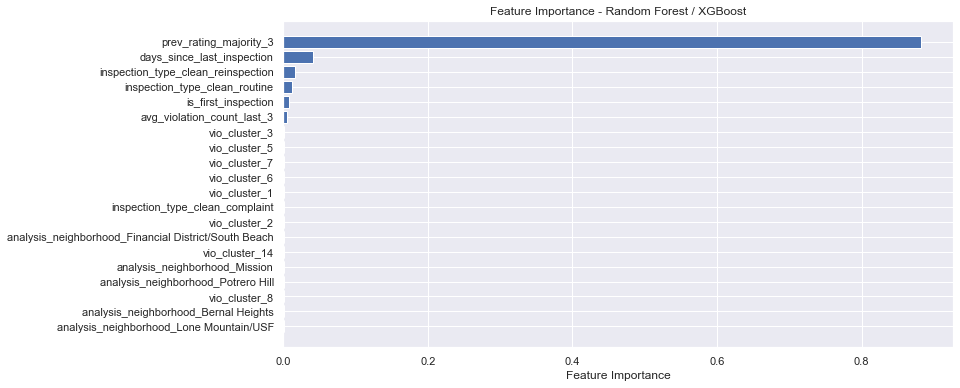

In [91]:
importances  = model.feature_importances_

feat_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(12,6))
plt.barh(feat_df['feature'], feat_df['importance'])
plt.gca().invert_yaxis()  # highest importance on top
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Random Forest / XGBoost')
plt.show()

## Weights XGBoost


In [92]:
split_idx = int(len(X_train) * 0.8)
X_train_inner_vio = X_train_vio[:split_idx].copy()
X_val_inner_vio  = X_train_vio[split_idx:].copy()
Y_train_inner_vio = Y_train_vio[:split_idx].copy()
Y_val_inner_vio  = Y_train_vio[split_idx:].copy()

In [93]:
class_weight_map = {0: 1, 1: 2, 2: 6}

sample_weight_inner = np.array([class_weight_map[y] for y in Y_train_inner])



In [103]:
model = XGBClassifier(random_state=42, subsample = 0.6, n_estimators = 200, min_child_weight = 1,
                      max_depth = 8, learning_rate = 0.01, gamma = 0, colsample_bytree = 0.6)

model.fit(X_train_inner_vio, Y_train_inner_vio, sample_weight=sample_weight_inner, eval_set=[(X_val_inner_vio, Y_val_inner_vio)],
    early_stopping_rounds=50,
    verbose=False
)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [104]:
print("TRAINING METRICS")
print("Accuracy:", model.score(X_train_inner_vio,Y_train_inner_vio))
print(classification_report(Y_train_inner_vio, model.predict(X_train_inner_vio)))


print("\nTEST METRICS")
print("Accuracy:", model.score(X_test_vio,Y_test_vio))
print(classification_report(Y_test_vio, model.predict(X_test_vio)))


TRAINING METRICS
Accuracy: 0.9577437910634934
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     30194
           1       0.97      0.80      0.88      4542
           2       0.97      0.74      0.84      1945

    accuracy                           0.96     36681
   macro avg       0.96      0.85      0.90     36681
weighted avg       0.96      0.96      0.96     36681


TEST METRICS
Accuracy: 0.9010787706085894
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     18014
           1       0.72      0.38      0.50      1045
           2       0.17      0.25      0.20       593

    accuracy                           0.90     19652
   macro avg       0.61      0.53      0.55     19652
weighted avg       0.91      0.90      0.90     19652



There is not much difference in adding violation_codes with minimal preprocessing. Strong NLP techniques might have made a difference

In [35]:
#features is necessary in upcoming visuals
df = pd.read_csv(r'../../data/clean/model_dataset.csv', keep_default_na = False)
features = [c for c in df.columns if c != target]


### XG Best Model

In [10]:
rus = RandomUnderSampler(
    sampling_strategy={0: 10000, 1: 5666, 2: 2507},
    random_state=42
)


In [11]:
X_train_us, Y_train_us = rus.fit_resample(X_train, Y_train)

In [12]:
xg_best_model = XGBClassifier(random_state=42, subsample = 0.6, n_estimators = 200, min_child_weight = 1,
                      max_depth = 8, learning_rate = 0.01, gamma = 0, colsample_bytree = 0.6)
xg_best_model.fit(X_train_us, Y_train_us)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [13]:
print("TRAINING METRICS")
print("Accuracy:", xg_best_model.score(X_train_us,Y_train_us))
print(classification_report(Y_train_us,xg_best_model.predict(X_train_us)))


print("\nTEST METRICS")
print("Accuracy:", xg_best_model.score(X_test,Y_test))
print(classification_report(Y_test,xg_best_model.predict(X_test)))


TRAINING METRICS
Accuracy: 0.8972651736092004
              precision    recall  f1-score   support

           0       0.85      0.99      0.92     10000
           1       0.98      0.80      0.88      5666
           2       0.99      0.73      0.84      2507

    accuracy                           0.90     18173
   macro avg       0.94      0.84      0.88     18173
weighted avg       0.91      0.90      0.89     18173


TEST METRICS
Accuracy: 0.927590067168736
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     18014
           1       0.66      0.39      0.49      1045
           2       0.47      0.25      0.33       593

    accuracy                           0.93     19652
   macro avg       0.69      0.54      0.59     19652
weighted avg       0.91      0.93      0.92     19652



In [14]:
#Saving the best XGBOOST model 
joblib.dump(xg_best_model, "xgboost_multiclass_latest.pkl")


['xgboost_multiclass_latest.pkl']

In [15]:

y_pred = xg_best_model.predict(X_test)
y_prob = xg_best_model.predict_proba(X_test)

metrics_xg = {"model_name": "XGBoost_latest"}

# Weighted/multiclass metrics
metrics_xg.update({
    "accuracy": accuracy_score(Y_test, y_pred),
    "precision_weighted": precision_score(Y_test, y_pred, average="weighted"),
    "recall_weighted": recall_score(Y_test, y_pred, average="weighted"),
    "f1_weighted": f1_score(Y_test, y_pred, average="weighted"),
    "roc_auc_weighted": roc_auc_score(Y_test, y_prob, multi_class="ovr", average="weighted")
})

# Per-class metrics and ROC curve info
metrics_xg["per_class"] = {}
classes = sorted(set(Y_test))
for cls in classes:
    y_true_cls = (Y_test == cls).astype(int)
    y_prob_cls = y_prob[:, cls]
    y_pred_cls = (y_pred == cls).astype(int)
    
    fpr, tpr, thresholds = roc_curve(y_true_cls, y_prob_cls)
    metrics_xg["per_class"][cls] = {
        "precision": precision_score(y_true_cls, y_pred_cls),
        "recall": recall_score(y_true_cls, y_pred_cls),
        "f1": f1_score(y_true_cls, y_pred_cls),
        "roc_auc": roc_auc_score(y_true_cls, y_prob_cls),
        "fpr": fpr,
        "tpr": tpr
    }

metrics_xg.update({
    "train_size": len(X_train),
    "val_size": len(X_test),
    "feature_set": list(features)
})


In [16]:
print(metrics_xg)

{'model_name': 'XGBoost_latest', 'accuracy': 0.927590067168736, 'precision_weighted': 0.9148489615643924, 'recall_weighted': 0.927590067168736, 'f1_weighted': 0.91815292891315, 'roc_auc_weighted': 0.7006738057926413, 'per_class': {0: {'precision': 0.9444622621338464, 'recall': 0.9808482291551016, 'f1': 0.9623114209465715, 'roc_auc': 0.6997007855645583, 'fpr': array([0.        , 0.        , 0.        , ..., 0.99023199, 0.995116  ,
       1.        ]), 'tpr': array([0.00000000e+00, 2.22049517e-04, 5.55123793e-04, ...,
       9.99944488e-01, 1.00000000e+00, 1.00000000e+00])}, 1: {'precision': 0.6591639871382636, 'recall': 0.3923444976076555, 'f1': 0.49190161967606477, 'roc_auc': 0.7415391336748042, 'fpr': array([0.00000000e+00, 0.00000000e+00, 5.37432149e-05, ...,
       9.99408825e-01, 9.99623797e-01, 1.00000000e+00]), 'tpr': array([0.       , 0.0076555, 0.015311 , ..., 1.       , 1.       ,
       1.       ])}, 2: {'precision': 0.4658385093167702, 'recall': 0.25295109612141653, 'f1': 0.

In [17]:
    
with open("xgboostmodellatest_metrics.pkl", "wb") as f:
    pickle.dump(metrics_xg, f)


Optimal threshold for class 2: 0.6823678
Best F1 score for class 2: 0.3892617417184452


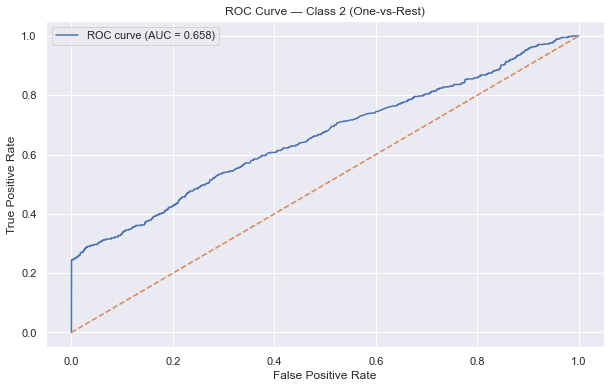

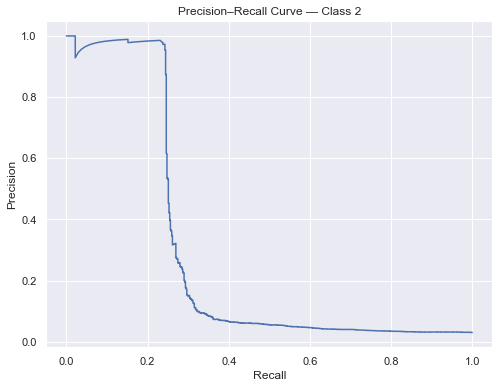

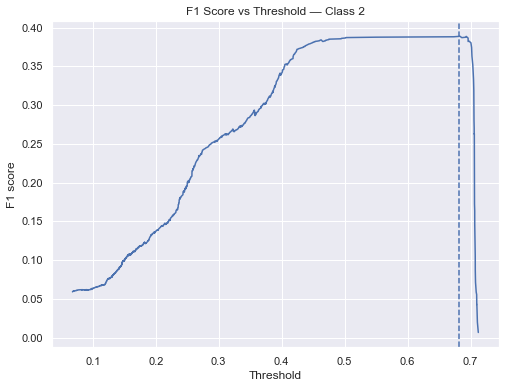

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    roc_auc_score
)

# Predict probabilities 
y_proba = xg_best_model.predict_proba(X_test)          
y_proba_class2 = y_proba[:, 2]                 

# Binary ground truth for class 2 (one-vs-rest)
y_test_bin = (Y_test == 2).astype(int)

# Precision–Recall + Threshold tuning
precision, recall, thresholds_pr = precision_recall_curve(
    y_test_bin,
    y_proba_class2
)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

optimal_idx = np.argmax(f1_scores[:-1])       
optimal_threshold = thresholds_pr[optimal_idx]

print("Optimal threshold for class 2:", optimal_threshold)
print("Best F1 score for class 2:", f1_scores[optimal_idx])

# ROC curve for class 2 
fpr, tpr, _ = roc_curve(y_test_bin, y_proba_class2)
roc_auc = roc_auc_score(y_test_bin, y_proba_class2)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Class 2 (One-vs-Rest)")
plt.legend()
plt.show()

# Precision–Recall curve 
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Class 2")
plt.show()

# F1 vs Threshold 
plt.figure(figsize=(8, 6))
plt.plot(thresholds_pr, f1_scores[:-1])
plt.axvline(optimal_threshold, linestyle="--")
plt.xlabel("Threshold")
plt.ylabel("F1 score")
plt.title("F1 Score vs Threshold — Class 2")
plt.show()


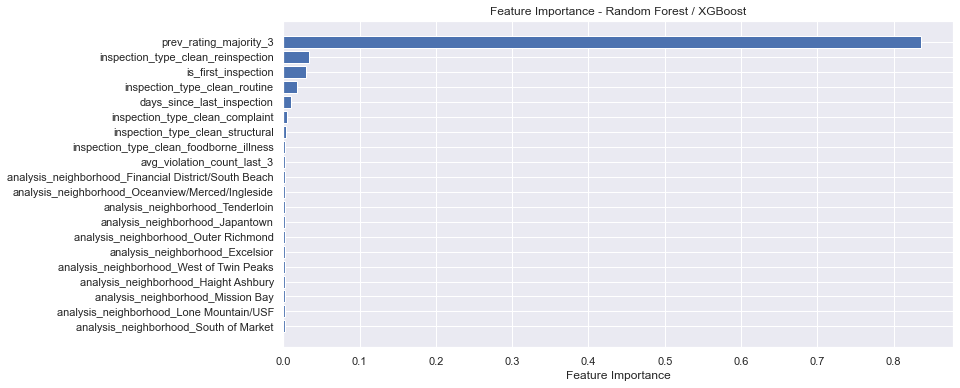

In [21]:
importances  = xg_best_model.feature_importances_

feat_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(12,6))
plt.barh(feat_df['feature'], feat_df['importance'])
plt.gca().invert_yaxis()  # highest importance on top
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Random Forest / XGBoost')
plt.show()

## Chosen Model

In [22]:
#Best model so far
rf_best_model = RandomForestClassifier(n_estimators = 200, min_samples_leaf = 10, max_features = 'sqrt', class_weight = {0: 1, 1: 2, 2: 4})
rf_best_model.fit(X_train,Y_train)

RandomForestClassifier(class_weight={0: 1, 1: 2, 2: 4}, max_features='sqrt',
                       min_samples_leaf=10, n_estimators=200)

In [23]:
print_score(rf_best_model)


Training Score: 
0.9565776847247667

Testing Score: 
0.9407185019336455

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37679
           1       0.99      0.78      0.87      5666
           2       0.98      0.73      0.84      2507

    accuracy                           0.96     45852
   macro avg       0.98      0.83      0.89     45852
weighted avg       0.96      0.96      0.95     45852


Test Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     18014
           1       0.96      0.35      0.51      1045
           2       0.83      0.24      0.38       593

    accuracy                           0.94     19652
   macro avg       0.91      0.53      0.62     19652
weighted avg       0.94      0.94      0.93     19652



In [24]:
#Saving the best model so far
joblib.dump(rf_best_model, "random_forest_multiclass.pkl")



['random_forest_multiclass.pkl']

In [28]:

y_pred = rf_best_model.predict(X_test)
y_prob = rf_best_model.predict_proba(X_test)

metrics_rf = {"model_name": "RF_latest"}

# Weighted/multiclass metrics
metrics_rf.update({
    "accuracy": accuracy_score(Y_test, y_pred),
    "precision_weighted": precision_score(Y_test, y_pred, average="weighted"),
    "recall_weighted": recall_score(Y_test, y_pred, average="weighted"),
    "f1_weighted": f1_score(Y_test, y_pred, average="weighted"),
    "roc_auc_weighted": roc_auc_score(Y_test, y_prob, multi_class="ovr", average="weighted")
})

# Per-class metrics and ROC curve info
metrics_rf["per_class"] = {}
classes = sorted(set(Y_test))
for cls in classes:
    y_true_cls = (Y_test == cls).astype(int)
    y_prob_cls = y_prob[:, cls]
    y_pred_cls = (y_pred == cls).astype(int)
    
    fpr, tpr, thresholds = roc_curve(y_true_cls, y_prob_cls)
    metrics_rf["per_class"][cls] = {
        "precision": precision_score(y_true_cls, y_pred_cls),
        "recall": recall_score(y_true_cls, y_pred_cls),
        "f1": f1_score(y_true_cls, y_pred_cls),
        "roc_auc": roc_auc_score(y_true_cls, y_prob_cls),
        "fpr": fpr,
        "tpr": tpr
    }

metrics_rf.update({
    "train_size": len(X_train),
    "val_size": len(X_test),
    "feature_set": list(features)
})


In [29]:
print(metrics_rf)

{'model_name': 'RF_latest', 'accuracy': 0.9407185019336455, 'precision_weighted': 0.9391589273848789, 'recall_weighted': 0.9407185019336455, 'f1_weighted': 0.92672259126941, 'roc_auc_weighted': 0.6913536439337973, 'per_class': {0: {'precision': 0.9412503927112786, 'recall': 0.9978905295880981, 'f1': 0.9687432636344039, 'roc_auc': 0.69000752094457, 'fpr': array([0.        , 0.        , 0.        , ..., 0.99084249, 0.996337  ,
       1.        ]), 'tpr': array([0.00000000e+00, 5.55123793e-05, 3.33074276e-04, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])}, 1: {'precision': 0.9631578947368421, 'recall': 0.35023923444976074, 'f1': 0.5136842105263157, 'roc_auc': 0.7366192380652135, 'fpr': array([0.00000000e+00, 0.00000000e+00, 5.37432149e-05, ...,
       9.98817649e-01, 9.99731284e-01, 1.00000000e+00]), 'tpr': array([0.        , 0.00861244, 0.01148325, ..., 1.        , 1.        ,
       1.        ])}, 2: {'precision': 0.8333333333333334, 'recall': 0.24451939291736932, 'f1': 0

In [30]:
with open("rfmodel_metrics.pkl", "wb") as f:
    pickle.dump(metrics_rf, f)


Optimal threshold for class 2: 0.6750646721439588
Best F1 score for class 2: 0.39083557630513444


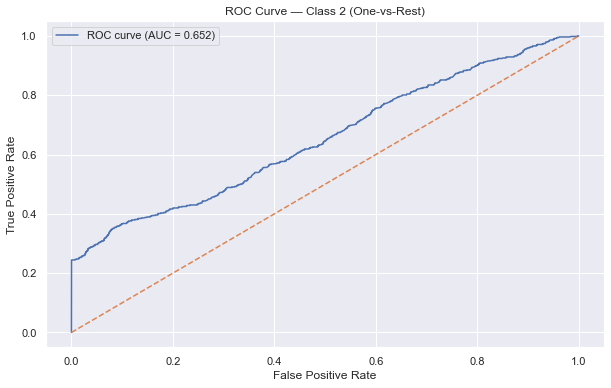

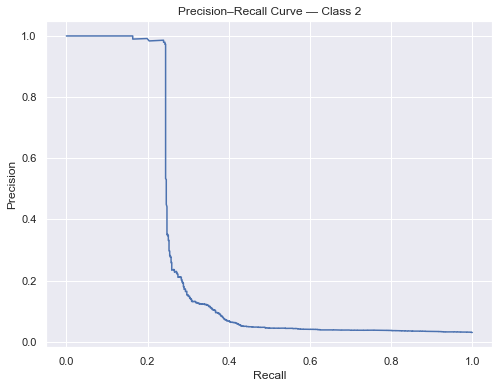

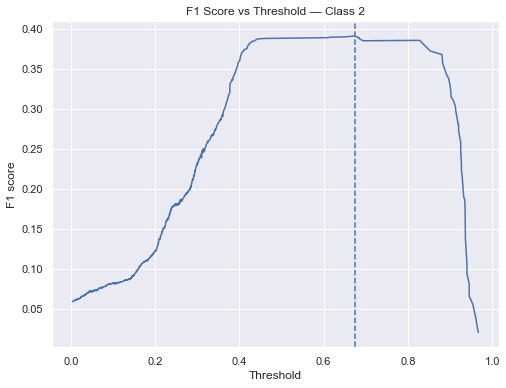

In [31]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    roc_auc_score
)

# Predict probabilities 
y_proba = rf_best_model.predict_proba(X_test)          
y_proba_class2 = y_proba[:, 2]                 

# Binary ground truth for class 2 (one-vs-rest)
y_test_bin = (Y_test == 2).astype(int)

# Precision–Recall + Threshold tuning
precision, recall, thresholds_pr = precision_recall_curve(
    y_test_bin,
    y_proba_class2
)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

optimal_idx = np.argmax(f1_scores[:-1])       
optimal_threshold = thresholds_pr[optimal_idx]

print("Optimal threshold for class 2:", optimal_threshold)
print("Best F1 score for class 2:", f1_scores[optimal_idx])

# ROC curve for class 2 
fpr, tpr, _ = roc_curve(y_test_bin, y_proba_class2)
roc_auc = roc_auc_score(y_test_bin, y_proba_class2)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Class 2 (One-vs-Rest)")
plt.legend()
plt.show()

# Precision–Recall curve 
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Class 2")
plt.show()

# F1 vs Threshold 
plt.figure(figsize=(8, 6))
plt.plot(thresholds_pr, f1_scores[:-1])
plt.axvline(optimal_threshold, linestyle="--")
plt.xlabel("Threshold")
plt.ylabel("F1 score")
plt.title("F1 Score vs Threshold — Class 2")
plt.show()


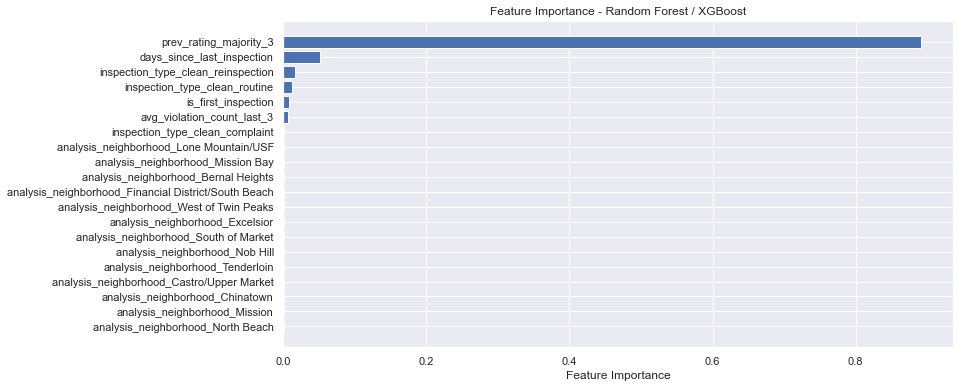

In [32]:
df = pd.read_csv(r'../../data/clean/model_dataset.csv', keep_default_na = False)
features = [c for c in df.columns if c != target]
importances  = rf_best_model.feature_importances_

feat_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(12,6))
plt.barh(feat_df['feature'], feat_df['importance'])
plt.gca().invert_yaxis()  # highest importance on top
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Random Forest / XGBoost')
plt.show()

## We could adjust the threshold to trade off between recall and precision according to our use case